Question: Can we integrate a RAG Pipeline?
Answer: Yes we can!

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings=GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm=ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hii").content

'Hello! How can I help you today?'

In [2]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_strings=[doc.page_content for doc in new_docs]

db=FAISS.from_documents(new_docs,embeddings)
reteriver=db.as_retriever(search_kwargs={"k":3})

query="what is meta llama?"
docs=reteriver.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

C:\Users\ayush\AppData\Local\Temp\ipykernel_32876\3250290832.py:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs=reteriver.get_relevant_documents(query)


{'source': 'data\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data\\llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': 'data\\llama3.txt'}
page_content='available as a foundation model.[8] Starting with Llama 2, Meta AI started releasing instruction' metadata={'source': 'data\\llama3.txt'}


In [4]:
def function_1(AgentState):
    message=AgentState["message"]

    question=message[-1]

    complete_prompt="Your task is to provide the brief answer based on the user query Don't include too much reasoning . Following is the user:" + question

    response=llm.invoke(complete_prompt)

    ## Appending LLm call response to the Agentstate
    AgentState["message"].append(response.content)

    return AgentState

In [5]:
def function_2(AgentState):
    message=AgentState['message']
    ## Fetching the user Question
    question=message[0]
    template=""" Answer the following based only on the following context:
    {context}

    Question:{question}
             """
    prompt=ChatPromptTemplate.from_template(template)

    reterival_chain=(
        {"context":reteriver,"question":RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result=reterival_chain.invoke(question)
    return result

In [6]:
## Define Langgraph
from langgraph.graph import Graph
workflow=Graph()
workflow.add_node("LLM",function_1)
workflow.add_node("RAGTOOL",function_2)
workflow.add_edge("LLM","RAGTOOL")
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGTOOL")
app=workflow.compile()


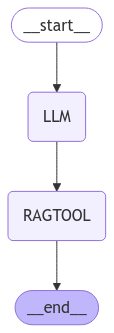

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [8]:
inputs={"message":["Tell me about llama3 model"]}

In [9]:
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("________")
        print(value)
        print("\n")

here is output from LLM
________
{'message': ['Tell me about llama3 model', 'LLaMA (Large Language Model Architect) is a family of large language models developed by Meta AI.']}


here is output from RAGTOOL
________
Llama 3 is a large language model developed by Meta AI. It has been compared favorably against other large language models, such as GPT-3 and Claude, in most benchmarks. The 8B parameter version of Llama 3 has been described as being "surprisingly capable" given its size.


